In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

%matplotlib qt

# matplotlib style = BLACK BACKGROUND, WHITE TEXT and AXES

# reset to default
plt.rcdefaults()
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'

In [2]:
# set seeds
np.random.seed()

In [3]:
T=60*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=3 # mm (width of the trail)

walking_speed=15 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=20 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)

N_REPLICATES=10
trajectories=[]

for N in range(N_REPLICATES):
    walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
    N=int(T*fps) # number of frames in the simulation
    state = np.zeros(N) # state of the fly (0=stop, 1=walking)
    heading = np.zeros(N) # heading of the fly (rad)
    x = np.zeros(N) # x position of the fly (mm)
    y = np.zeros(N) # y position of the fly (mm)
    odors = np.zeros((N,2)) # odor concentration at the left and right antennae


    heading[0]=np.random.rand()*2*np.pi # initial heading
    at_wall=False
    odor_asymmetry_seen=False

    for i in tqdm(range(1,N)):
        # update state
        if state[i-1]==0: # in the stop state
            if np.random.rand()<rate_stop_to_walk: # transition to walking state
                state[i]=1
            else:
                state[i]=0
        else:
            if np.random.rand()<rate_walk_to_stop: # transition to stop state
                state[i]=0
            else:
                state[i]=1
        
        # get left and right antennal positions
        left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
        left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
        right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
        right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance
        odor_left=get_odor(left_x,left_y)
        odor_right=get_odor(right_x,right_y)
        
        # update odor estimate assuming decay process
        odors[i,0]=odors[i-1,0]+(odor_left*odor_magnitude-odors[i-1,0])/odor_integration_timescale
        odors[i,1]=odors[i-1,1]+(odor_right*odor_magnitude-odors[i-1,1])/odor_integration_timescale

        # update position based on state
        if state[i]==0: # in the stop state
            x[i]=x[i-1]
            y[i]=y[i-1]
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        else: # in the walking state
            # sample a turn
            if odors[i,0]>odors[i,1]:
                turn_direction=1
                # print('left')
            elif odors[i,0]<odors[i,1]:
                turn_direction=-1
                # print('right')
            else:
                turn_direction=np.random.choice([-1,1])

            if at_wall: # if fly is at the wall, it must turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
                at_wall=False
            elif np.random.rand()<turn_rate+np.abs(odors[i,0]-odors[i,1])*asymmetry_factor: # turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            else:
                heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
            # move forward
            new_x=x[i-1]+np.cos(heading[i])*walking_distance
            new_y=y[i-1]+np.sin(heading[i])*walking_distance
            # check if fly is outside the arena
            if np.sqrt(new_x**2+new_y**2)>arena_radius:
                # animal stops at the wall
                x[i]=x[i-1]
                y[i]=y[i-1]
                at_wall=True
            else:
                x[i]=new_x
                y[i]=new_y

    trajectories.append(np.array((x,y,odors[:,0],odors[:,1],heading)))



  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

In [162]:
import pandas as pd
df= [pd.DataFrame(trajectories[i].T,columns=['x','y','odor_left','odor_right','heading']) for i in range(N_REPLICATES)]
# add replicate number
for i in range(N_REPLICATES):
    df[i]['replicate']=i
# concatenate
df=pd.concat(df)

In [278]:
# plot a hexbin of the positions
fig,ax=plt.subplots()
# log scale
hb=ax.hexbin(df['x'],df['y'],gridsize=100,cmap='inferno',bins='log',mincnt=1)
plt.colorbar(hb,label='occupancy')
ax.set_aspect('equal')
plt.axis('off')
plt.show()

In [291]:
# plot the trajectory
top_segments=[]
fig,ax=plt.subplots(2,5,figsize=(12,5))
for i in range(N_REPLICATES):
    data = df[df['replicate']==i]
    # ax[i].plot(df[df['replicate']==i]['x'],df[df['replicate']==i]['y'],color='white',alpha=0.1,lw=0.5)
    ax.flatten()[i].plot(data['x'],data['y'],color='white',alpha=0.5,lw=0.1)
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data for _,data in data.groupby('segment')]
    displacements=[(np.sqrt((np.diff(d['x'])**2+np.diff(d['y'])**2))[d['in_trail'][1:]]).sum() for d in data]
    # sort the data by displacement
    sort_index=np.argsort(displacements)
    data=[data[i] for i in sort_index]
    for n,d in enumerate(data[-5:]):
        ax.flatten()[i].plot(d['x'],d['y'],color=plt.cm.Reds(n/5),lw=1)
    top_segments.append(data[-1].copy().reset_index(drop=True))
    circle = plt.Circle((0,0),trail_radius-trail_width/2,fill=False,edgecolor='white',lw=0.2)
    ax.flatten()[i].add_artist(circle)
    circle = plt.Circle((0,0),trail_radius+trail_width/2,fill=False,edgecolor='white',lw=0.2)
    ax.flatten()[i].add_artist(circle)
    ax.flatten()[i].set_aspect('equal')
    ax.flatten()[i].set_xlim(-arena_radius,arena_radius)
    ax.flatten()[i].set_ylim(-arena_radius,arena_radius)
    ax.flatten()[i].axis('off')
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/3770296621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/3770296621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((d

In [292]:
# downsample fps
downsampled_fps = 10
top_segments = [s[::int(fps/downsampled_fps)] for s in top_segments]
durations = [len(s) for s in top_segments]
max_duration = max(durations)

In [293]:
# Save as a video (openCV mp4)
import cv2
WIDTH, HEIGHT = 512, 512
SPEEDUP=4

scale_factor = WIDTH/(2*arena_radius)

# setup the background as a 3x3 grid
background = np.ones((3*WIDTH,3*HEIGHT,3),dtype=np.uint8)*0
# draw the arenas and the trail
for i in range(3):
    for j in range(3):
        cv2.circle(background, (int(WIDTH/2)+i*WIDTH,int(HEIGHT/2)+j*HEIGHT), int(arena_radius*scale_factor), (255,255,255), 2)
        cv2.circle(background, (int(WIDTH/2)+i*WIDTH,int(HEIGHT/2)+j*HEIGHT), int(trail_radius*scale_factor), (0,0,100), int(trail_width*scale_factor))

# add text on the background
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(background,'Simulated Encounters',(20,50), font, 2,(255,255,255),1,cv2.LINE_AA)
cv2.putText(background,'Speedup x{}'.format(SPEEDUP),(20,120), font, 2,(255,255,255),1,cv2.LINE_AA)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('top_simulated_encounters.mp4', fourcc, downsampled_fps*SPEEDUP, (3*WIDTH,3*HEIGHT))

for t in tqdm(range(1,max_duration)):
    # create an overlay
    overlay = background.copy()
    # plot the top encounters on the overlay
    for i in range(9):
        center = (int(WIDTH/2)+WIDTH*(i%3),int(HEIGHT/2)+HEIGHT*(i//3))
        x,y = top_segments[i]['x'][:min(t,durations[i])], top_segments[i]['y'][:min(t,durations[i])]
        x,y = x*scale_factor,y*scale_factor
        x,y = x+center[0],y+center[1]
        x,y = x.astype(int).values,y.astype(int).values
        # draw the fly on the overlay
        cv2.circle(overlay, (int(x[-1]),int(y[-1])), 10, (255,255,255), -1)
        # add the last step to the background
        if len(x)>1:
            cv2.line(background,(int(x[-2]),int(y[-2])),(int(x[-1]),int(y[-1])),(255,255,255),2)

    # add the overlay to the video
    video.write(overlay)
video.release()

        
        

  0%|          | 0/121 [00:00<?, ?it/s]

In [224]:
# plot the trajectory
fig,ax=plt.subplots(1,5,figsize=(12,5),sharex=True,sharey=True)
for i in range(5):
    data = df[df['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['position']=np.unwrap(np.arctan2(data['y'],data['x']))*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
    # plot distance from the trail vs angle
    for d in data:
        ax[i].plot(d['distance'],d['position'],color='white',alpha=1,lw=0.2)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(-trail_width-10,trail_width+10)
    # draw the trail
    ax[i].fill_between([-trail_width/2,trail_width/2],[-30,-30],[120,120],color='red',alpha=0.3)
    ax[i].spines['left'].set_visible(False if i>0 else True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    # set tick marker color
    ax[i].tick_params(axis='y', colors='white' if i==0 else 'black')
    # ax[i].axis('off')
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/50580315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['heading']=data['heading']%(2*np.pi)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/50580315.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/50580315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [227]:
# plot the trajectory
all_segments=[]
for i in range(N_REPLICATES):
    data = df[df['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['angle']=np.arctan2(data['y'],data['x'])
    data['position']=np.unwrap(data['angle'])*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['entry_point'] = entry_points[n]
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
        # calculate the displacement
        data[n]['displacement']=(np.sqrt((np.diff(data[n]['x'])**2+np.diff(data[n]['y'])**2))[entry_points[n]:]).sum()
        # calculate the maximum distance along the trail
        data[n]['max_distance']=data[n]['position'].abs().max()

    # calculate the motion direction and speed and displacement
    for d in data:
        direction = np.arctan2(np.diff(d['y']),np.diff(d['x']))
        d['direction']= np.r_[direction[0],direction]
        # relative direction
        d['relative_direction']=(d['direction']%(2*np.pi)-d['angle']%(2*np.pi))%(2*np.pi)
        speed = np.sqrt(np.diff(d['x'])**2+np.diff(d['y'])**2)*fps
        d['speed']=np.r_[speed[0],speed]
    all_segments+=data
    
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/2965413961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['heading']=data['heading']%(2*np.pi)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/2965413961.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/2965413961.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [237]:
# plot the trajectory
all_segments=[]
for i in range(N_REPLICATES):
    data = df[df['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['angle']=np.arctan2(data['y'],data['x'])
    data['position']=np.unwrap(data['angle'])*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['entry_point'] = entry_points[n]
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
        # calculate the displacement
        data[n]['displacement']=(np.sqrt((np.diff(data[n]['x'])**2+np.diff(data[n]['y'])**2))[entry_points[n]:]).sum()
        # calculate the maximum distance along the trail
        data[n]['max_distance']=data[n]['position'].abs().max()

    # calculate the motion direction and speed and displacement
    for d in data:
        direction = np.arctan2(np.diff(d['y']),np.diff(d['x']))
        d['direction']= np.r_[direction[0],direction]
        # relative direction
        d['relative_direction']=(d['direction']%(2*np.pi)-d['angle']%(2*np.pi))%(2*np.pi)
        speed = np.sqrt(np.diff(d['x'])**2+np.diff(d['y'])**2)*fps
        d['speed']=np.r_[speed[0],speed]
    all_segments+=data
    
plt.show()

# plot the displacement vs average motion direction prior to entry
fig,ax=plt.subplots(1,1,figsize=(5,5))
motion_directions=[]
displacements=[]
for d in all_segments:
    motion_directions.append(d['relative_direction'][:d['entry_point'].iloc[0]].mean())
    displacements.append(d['max_distance'].iloc[0])
ax.scatter(motion_directions,displacements, color='white', edgecolor='black', s=15)
# binned average
bins = np.arange(0, 2*np.pi+0.1, np.pi/8)
binned_displacements=[]
for i in range(len(bins)-1):
    idx=np.logical_and(np.array(motion_directions)>bins[i],np.array(motion_directions)<bins[i+1])
    binned_displacements.append(np.mean(np.array(displacements)[idx]))
ax.plot((bins[1:]+bins[:-1])/2,binned_displacements,color='white',lw=2)
ax.set_xlim(0,2*np.pi)
ax.set_xlabel('Angle with respect to the trail (rad)')
ax.set_ylabel('Displacement (mm)')
plt.xticks( np.arange(0, 2*np.pi+0.1, np.pi/2), ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### ABLATION

In [163]:
T=60*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=3 # mm (width of the trail)

walking_speed=15 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=20 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)

N_REPLICATES=10
trajectories=[]

for N in range(N_REPLICATES):
    ablations = np.random.choice([0,1],size=2,replace=False)
    print(ablations)
    walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
    N=int(T*fps) # number of frames in the simulation
    state = np.zeros(N) # state of the fly (0=stop, 1=walking)
    heading = np.zeros(N) # heading of the fly (rad)
    x = np.zeros(N) # x position of the fly (mm)
    y = np.zeros(N) # y position of the fly (mm)
    odors = np.zeros((N,2)) # odor concentration at the left and right antennae


    heading[0]=np.random.rand()*2*np.pi # initial heading
    at_wall=False

    for i in tqdm(range(1,N)):
        # update state
        if state[i-1]==0: # in the stop state
            if np.random.rand()<rate_stop_to_walk: # transition to walking state
                state[i]=1
            else:
                state[i]=0
        else:
            if np.random.rand()<rate_walk_to_stop: # transition to stop state
                state[i]=0
            else:
                state[i]=1
        
        # get left and right antennal positions
        left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
        left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
        right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
        right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance
        odor_left=get_odor(left_x,left_y)*ablations[0]
        odor_right=get_odor(right_x,right_y)*ablations[1]
        
        # update odor estimate assuming decay process
        odors[i,0]=odors[i-1,0]+(odor_left*odor_magnitude-odors[i-1,0])/odor_integration_timescale
        odors[i,1]=odors[i-1,1]+(odor_right*odor_magnitude-odors[i-1,1])/odor_integration_timescale

        # update position based on state
        if state[i]==0: # in the stop state
            x[i]=x[i-1]
            y[i]=y[i-1]
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        else: # in the walking state
            # sample a turn
            if odors[i,0]>odors[i,1]:
                turn_direction=1
                # print('left')
            elif odors[i,0]<odors[i,1]:
                turn_direction=-1
                # print('right')
            else:
                turn_direction=np.random.choice([-1,1])

            if at_wall: # if fly is at the wall, it must turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
                at_wall=False
            elif np.random.rand()<turn_rate+np.abs(odors[i,0]-odors[i,1])*asymmetry_factor: # turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            else:
                heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
            # move forward
            new_x=x[i-1]+np.cos(heading[i])*walking_distance
            new_y=y[i-1]+np.sin(heading[i])*walking_distance
            # check if fly is outside the arena
            if np.sqrt(new_x**2+new_y**2)>arena_radius:
                # animal stops at the wall
                x[i]=x[i-1]
                y[i]=y[i-1]
                at_wall=True
            else:
                x[i]=new_x
                y[i]=new_y

    trajectories.append(np.array((x,y,odors[:,0],odors[:,1],heading)))



[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[1 0]


  0%|          | 0/215999 [00:00<?, ?it/s]

[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[1 0]


  0%|          | 0/215999 [00:00<?, ?it/s]

[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[0 1]


  0%|          | 0/215999 [00:00<?, ?it/s]

[1 0]


  0%|          | 0/215999 [00:00<?, ?it/s]

In [164]:
import pandas as pd
df_ablation= [pd.DataFrame(trajectories[i].T,columns=['x','y','odor_left','odor_right','heading']) for i in range(N_REPLICATES)]
# add replicate number
for i in range(N_REPLICATES):
    df_ablation[i]['replicate']=i
# concatenate
df_ablation=pd.concat(df_ablation)

In [284]:
# plot a hexbin of the positions
fig,ax=plt.subplots()
# log scale
hb=ax.hexbin(df_ablation['x'],df_ablation['y'],gridsize=100,cmap='inferno',bins='log',mincnt=1)
plt.colorbar(hb,label='occupancy')
ax.set_aspect('equal')
plt.axis('off')
plt.show()

In [287]:
# plot the trajectory
top_segments=[]
fig,ax=plt.subplots(2,5,figsize=(12,5))
for i in range(N_REPLICATES):
    data = df_ablation[df_ablation['replicate']==i]
    ax.flatten()[i].plot(data['x'],data['y'],color='white',alpha=0.5,lw=0.1)
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data for _,data in data.groupby('segment')]
    displacements=[(np.sqrt((np.diff(d['x'])**2+np.diff(d['y'])**2))[d['in_trail'][1:]]).sum() for d in data]
    # sort the data by displacement
    sort_index=np.argsort(displacements)
    data=[data[i] for i in sort_index]
    for n,d in enumerate(data[-5:]):
        ax.flatten()[i].plot(d['x'],d['y'],color=plt.cm.Reds(n/5),lw=1)
    top_segments.append(data[-1].copy().reset_index(drop=True))
    # draw the circle
    circle = plt.Circle((0,0),trail_radius-trail_width/2,fill=False,edgecolor='white',lw=0.5)
    ax.flatten()[i].add_artist(circle)
    circle = plt.Circle((0,0),trail_radius+trail_width/2,fill=False,edgecolor='white',lw=0.5)
    ax.flatten()[i].add_artist(circle)
    ax.flatten()[i].set_aspect('equal')
    ax.flatten()[i].set_xlim(-arena_radius,arena_radius)
    ax.flatten()[i].set_ylim(-arena_radius,arena_radius)
    ax.flatten()[i].axis('off')
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/1642772115.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/1642772115.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((da

In [288]:
# downsample fps
downsampled_fps = 10
top_segments = [s[::int(fps/downsampled_fps)] for s in top_segments]
durations = [len(s) for s in top_segments]
max_duration = max(durations)

In [290]:
# Save as a video (openCV mp4)
import cv2
WIDTH, HEIGHT = 512, 512
SPEEDUP=4

scale_factor = WIDTH/(2*arena_radius)

# setup the background as a 3x3 grid
background = np.ones((3*WIDTH,3*HEIGHT,3),dtype=np.uint8)*0
# draw the arenas and the trail
for i in range(3):
    for j in range(3):
        cv2.circle(background, (int(WIDTH/2)+i*WIDTH,int(HEIGHT/2)+j*HEIGHT), int(arena_radius*scale_factor), (255,255,255), 2)
        cv2.circle(background, (int(WIDTH/2)+i*WIDTH,int(HEIGHT/2)+j*HEIGHT), int(trail_radius*scale_factor), (0,0,100), int(trail_width*scale_factor))

# add text on the background
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(background,'Simulated Encounters',(20,50), font, 2,(255,255,255),1,cv2.LINE_AA)
cv2.putText(background,'Speedup x{}'.format(SPEEDUP),(20,120), font, 2,(255,255,255),1,cv2.LINE_AA)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('top_simulated_encounters_abl.mp4', fourcc, downsampled_fps*SPEEDUP, (3*WIDTH,3*HEIGHT))

for t in tqdm(range(1,max_duration)):
    # create an overlay
    overlay = background.copy()
    # plot the top encounters on the overlay
    for i in range(9):
        center = (int(WIDTH/2)+WIDTH*(i%3),int(HEIGHT/2)+HEIGHT*(i//3))
        x,y = top_segments[i]['x'][:min(t,durations[i])], top_segments[i]['y'][:min(t,durations[i])]
        x,y = x*scale_factor,y*scale_factor
        x,y = x+center[0],y+center[1]
        x,y = x.astype(int).values,y.astype(int).values
        # draw the fly on the overlay
        cv2.circle(overlay, (int(x[-1]),int(y[-1])), 10, (255,255,255), -1)
        # add the last step to the background
        if len(x)>1:
            cv2.line(background,(int(x[-2]),int(y[-2])),(int(x[-1]),int(y[-1])),(255,255,255),2)

    # add the overlay to the video
    video.write(overlay)
video.release()

  0%|          | 0/213 [00:00<?, ?it/s]

In [285]:
# plot the trajectory
fig,ax=plt.subplots(1,1,figsize=(5,7),sharex=True,sharey=True)
for i in range(5):
    data = df_ablation[df_ablation['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['position']=np.unwrap(np.arctan2(data['y'],data['x']))*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
    # plot distance from the trail vs angle
    for d in data:
        ax.plot(d['distance'],d['position'],color='white',alpha=0.7,lw=0.2)
    ax.set_aspect('equal')
    ax.set_xlim(-trail_width-10,trail_width+10)
    ax.fill_between([-trail_width/2,trail_width/2],[-20,-20],[350,350],color='red',alpha=0.3)
    ax.set_ylim(-20,330)
    ax.spines['left'].set_visible(False if i>0 else True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # reduce x ticks font size
    plt.xticks(fontsize=6)
    # ax[i].axis('off')
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/2484871308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['heading']=data['heading']%(2*np.pi)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/2484871308.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/2484871308.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [286]:
# plot the trajectory
all_segments=[]
for i in range(N_REPLICATES):
    data = df_ablation[df_ablation['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['angle']=np.arctan2(data['y'],data['x'])
    data['position']=np.unwrap(data['angle'])*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['entry_point'] = entry_points[n]
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
        # calculate the displacement
        data[n]['displacement']=(np.sqrt((np.diff(data[n]['x'])**2+np.diff(data[n]['y'])**2))[entry_points[n]:]).sum()
        # calculate the maximum distance along the trail
        data[n]['max_distance']=data[n]['position'].abs().max()

    # calculate the motion direction and speed and displacement
    for d in data:
        direction = np.arctan2(np.diff(d['y']),np.diff(d['x']))
        d['direction']= np.r_[direction[0],direction]
        # relative direction
        d['relative_direction']=(d['direction']%(2*np.pi)-d['angle']%(2*np.pi))%(2*np.pi)
        speed = np.sqrt(np.diff(d['x'])**2+np.diff(d['y'])**2)*fps
        d['speed']=np.r_[speed[0],speed]
    all_segments+=data
    
plt.show()

# plot the displacement vs average motion direction prior to entry
fig,ax=plt.subplots(1,1,figsize=(5,5))
motion_directions=[]
displacements=[]
for d in all_segments:
    motion_directions.append(d['relative_direction'][:d['entry_point'].iloc[0]].mean())
    displacements.append(d['max_distance'].iloc[0])
ax.scatter(motion_directions,displacements, color='white', edgecolor='black', s=15)
# binned average
bins = np.arange(0, 2*np.pi+0.1, np.pi/8)
binned_displacements=[]
for i in range(len(bins)-1):
    idx=np.logical_and(np.array(motion_directions)>bins[i],np.array(motion_directions)<bins[i+1])
    binned_displacements.append(np.mean(np.array(displacements)[idx]))
ax.plot((bins[1:]+bins[:-1])/2,binned_displacements,color='white',lw=2)
ax.set_xlim(0,2*np.pi)
ax.set_xlabel('Angle with respect to the trail (rad)')
ax.set_ylabel('Displacement (mm)')
plt.xticks( np.arange(0, 2*np.pi+0.1, np.pi/2), ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/3295034708.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['heading']=data['heading']%(2*np.pi)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/3295034708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_26566/3295034708.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

### ABLATION VS NON-ABLATION

In [167]:
# not ablated
single_contact_segments_normal=[]
all_encounters_normal=[]
for i in range(N_REPLICATES):
    data = df[df['replicate']==i]
    data['distance'] = np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # add to the list
    all_encounters_normal+=data
    n_encounters=len(data)
    # the points of transition from out of the trail to in the trail
    entry_points=[np.where(np.diff(d['in_trail'].astype(int))>0)[0] for d in data]
    # keep only the segments with a single entry point
    data=[d for d,e in zip(data,entry_points) if len(e)==1]
    # only keep if the start and the end are the same sign for the distance
    data=[d for d in data if d['distance'].iloc[0]*d['distance'].iloc[-1]>0]
    # add to the list
    single_contact_segments_normal.append(len(data)/n_encounters)

# ablated
single_contact_segments_ablation=[]
all_encounters_ablation=[]
for i in range(N_REPLICATES):
    data = df_ablation[df_ablation['replicate']==i]
    data['distance'] = np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # add to the list
    all_encounters_ablation+=data
    n_encounters=len(data)
    # the points of transition from out of the trail to in the trail
    entry_points=[np.where(np.diff(d['in_trail'].astype(int))>0)[0] for d in data]
    # keep only the segments with a single entry point
    data=[d for d,e in zip(data,entry_points) if len(e)==1]
    # only keep if the start and the end are the same sign for the distance
    data=[d for d in data if d['distance'].iloc[0]*d['distance'].iloc[-1]>0]
    # add to the list
    single_contact_segments_ablation.append(len(data)/n_encounters)
# plot the two distributions as box plots with scatter
fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.boxplot([single_contact_segments_normal,single_contact_segments_ablation],positions=[0,1], widths=0.6)
ax.scatter(np.zeros(N_REPLICATES)+0.5*np.random.uniform(-0.1,0.1,N_REPLICATES),single_contact_segments_normal,color='white',alpha=1,s=50,edgecolor='black')
ax.scatter(np.ones(N_REPLICATES)+0.5*np.random.uniform(-0.1,0.1,N_REPLICATES),single_contact_segments_ablation,color='white',alpha=1,s=50,edgecolor='black')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal','Ablation'])
ax.set_ylabel('Fraction of "hit and run" encounters')
# ax.set_yscale('log')
plt.box(False)
plt.tight_layout()
plt.show()


    

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/3816459358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance'] = np.sqrt(data['x']**2+data['y']**2)-trail_radius
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/3816459358.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
/var/folders/yj/5_b3w2q176x67w9497

In [179]:
# plot trajectory density wrt distance from the trail
fig,ax=plt.subplots(1,1,figsize=(2.3,2))
distances = []
for d in all_encounters_normal:
    distances+=d['distance'].tolist()
ax.hist(distances,bins=40,density=True,color='white',alpha=0.5)
# show the trail
plt.fill_between([-trail_width/2,trail_width/2],[0,0],[0.1,0.1],color='red',alpha=0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
plt.xlabel('Distance from the trail (mm)')
plt.tight_layout()
plt.show()  

# plot trajectory density wrt distance from the trail
fig,ax=plt.subplots(1,1,figsize=(2.3,2))
distances = []
for d in all_encounters_ablation:
    distances+=d['distance'].tolist()
ax.hist(distances,bins=40,density=True,color='white',alpha=0.5)
# show the trail
plt.fill_between([-trail_width/2,trail_width/2],[0,0],[0.1,0.1],color='red',alpha=0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
plt.xlabel('Distance from the trail (mm)')
plt.tight_layout()
plt.show()


### ADAPTATION TO Hasselstein-Reinhardt Correlators

In [152]:
T=60*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=12.5 # mm (width of the trail)

walking_speed=15 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=10 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

adaptation_timescale=5/fps # s (timescale of adaptation)
adaptation_magnitude=0.5 # (magnitude of the adaptation signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)
adaptation_timescale=adaptation_timescale*fps # frames (timescale of adaptation)

N_REPLICATES=10
trajectories=[]

for N in range(N_REPLICATES):
    walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
    N=int(T*fps) # number of frames in the simulation
    state = np.zeros(N) # state of the fly (0=stop, 1=walking)
    heading = np.zeros(N) # heading of the fly (rad)
    x = np.zeros(N) # x position of the fly (mm)
    y = np.zeros(N) # y position of the fly (mm)
    odors = np.zeros((N,2)) # odor concentration at the left and right antennae
    adaptation = np.zeros((N,2)) # adaptation of the left and right antennae

    heading[0]=np.random.rand()*2*np.pi # initial heading
    at_wall=False

    for i in tqdm(range(1,N)):
        # update state
        if state[i-1]==0: # in the stop state
            if np.random.rand()<rate_stop_to_walk: # transition to walking state
                state[i]=1
            else:
                state[i]=0
        else:
            if np.random.rand()<rate_walk_to_stop: # transition to stop state
                state[i]=0
            else:
                state[i]=1
        
        # get left and right antennal positions
        left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
        left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
        right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
        right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance

        odor_left=get_odor(left_x,left_y)
        odor_right=get_odor(right_x,right_y)
        
        # update odor estimate assuming decay process
        odors[i,0]=odors[i-1,0] + 1/odor_integration_timescale * (-odors[i-1,0] + odor_left*odor_magnitude - adaptation[i-1,0])
        odors[i,1]=odors[i-1,1] + 1/odor_integration_timescale * (-odors[i-1,1] + odor_right*odor_magnitude - adaptation[i-1,1])

        # update adaptation
        adaptation[i,0]=adaptation[i-1,0] + 1/adaptation_timescale * (-adaptation[i-1,0] + adaptation_magnitude*odors[i-1,0])
        adaptation[i,1]=adaptation[i-1,1] + 1/adaptation_timescale * (-adaptation[i-1,1] + adaptation_magnitude*odors[i-1,1])

        # update position based on state
        if state[i]==0: # in the stop state
            x[i]=x[i-1]
            y[i]=y[i-1]
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        else: # in the walking state
            # sample a turn
            if odors[i,0]>odors[i,1]:
                turn_direction=1
                # print('left')
            elif odors[i,0]<odors[i,1]:
                turn_direction=-1
                # print('right')
            else:
                turn_direction=np.random.choice([-1,1])

            if at_wall: # if fly is at the wall, it must turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
                at_wall=False
            elif np.random.rand()<turn_rate+np.abs(odors[i,0]-odors[i,1])*asymmetry_factor: # turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            else:
                heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
            # move forward
            new_x=x[i-1]+np.cos(heading[i])*walking_distance
            new_y=y[i-1]+np.sin(heading[i])*walking_distance
            # check if fly is outside the arena
            if np.sqrt(new_x**2+new_y**2)>arena_radius:
                # animal stops at the wall
                x[i]=x[i-1]
                y[i]=y[i-1]
                at_wall=True
            else:
                x[i]=new_x
                y[i]=new_y

    trajectories.append(np.array((x,y,odors[:,0],odors[:,1],heading)))


df_adaptation= [pd.DataFrame(trajectories[i].T,columns=['x','y','odor_left','odor_right','heading']) for i in range(N_REPLICATES)]
# add replicate number
for i in range(N_REPLICATES):
    df_adaptation[i]['replicate']=i
# concatenate
df_adaptation=pd.concat(df_adaptation)


  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

In [153]:
# plot a hexbin of the positions
fig,ax=plt.subplots()
# log scale
hb=ax.hexbin(df_adaptation['x'],df_adaptation['y'],gridsize=100,cmap='inferno',bins='log',mincnt=1)
# draw the circle
circle = plt.Circle((0,0),trail_radius-trail_width/2,fill=False,edgecolor='white',lw=0.5)
ax.add_artist(circle)
circle = plt.Circle((0,0),trail_radius+trail_width/2,fill=False,edgecolor='white',lw=0.5)
ax.add_artist(circle)
plt.colorbar(hb,label='occupancy')
ax.set_aspect('equal')
plt.axis('off')
plt.show()

# plot the trajectory
top_segments=[]
fig,ax=plt.subplots(2,5,figsize=(12,5))
for i in range(N_REPLICATES):
    data = df_adaptation[df_adaptation['replicate']==i]
    ax.flatten()[i].plot(data['x'],data['y'],color='white',alpha=0.5,lw=0.1)
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data for _,data in data.groupby('segment')]
    displacements=[(np.sqrt((np.diff(d['x'])**2+np.diff(d['y'])**2))[d['in_trail'][1:]]).sum() for d in data]
    # sort the data by displacement
    sort_index=np.argsort(displacements)
    data=[data[i] for i in sort_index]
    for n,d in enumerate(data[-5:]):
        ax.flatten()[i].plot(d['x'],d['y'],color=plt.cm.Reds(n/5),lw=1)
    top_segments.append(data[-1].copy().reset_index(drop=True))
    # draw the circle
    circle = plt.Circle((0,0),trail_radius-trail_width/2,fill=False,edgecolor='white',lw=0.5)
    ax.flatten()[i].add_artist(circle)
    circle = plt.Circle((0,0),trail_radius+trail_width/2,fill=False,edgecolor='white',lw=0.5)
    ax.flatten()[i].add_artist(circle)
    ax.flatten()[i].set_aspect('equal')
    ax.flatten()[i].set_xlim(-arena_radius,arena_radius)
    ax.flatten()[i].set_ylim(-arena_radius,arena_radius)
    ax.flatten()[i].axis('off')
plt.show()
# plot the trajectory
fig,ax=plt.subplots(1,1,figsize=(5,7),sharex=True,sharey=True)
all_data = []
for i in range(5):
    data = df_adaptation[df_adaptation['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['position']=np.unwrap(np.arctan2(data['y'],data['x']))*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
    # plot distance from the trail vs angle
    for d in data:
        ax.plot(d['distance'],d['position'],color='white',alpha=0.7,lw=0.2)
        all_data.append(d)
    ax.set_aspect('equal')
    ax.set_xlim(-trail_width-10,trail_width+10)
    ax.fill_between([-trail_width/2,trail_width/2],[-20,-20],[500,500],color='red',alpha=0.3)
    ax.set_ylim(-20,500)
    ax.spines['left'].set_visible(False if i>0 else True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # reduce x ticks font size
    plt.xticks(fontsize=6)
    # ax[i].axis('off')
plt.show()
# plot a distance density plot
fig,ax=plt.subplots(1,1,figsize=(5,3))
distances = np.concatenate([d['distance'].values for d in all_data])
# plot the density
plt.hist(distances,bins=100,density=True,color='white',alpha=0.5)
# draw the trail
plt.fill_between([-trail_width/2,trail_width/2],[0,0],[0.1,0.1],color='red',alpha=0.3,zorder=-1)
ax.set_xlabel('Distance from the trail (mm)')
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/4092089064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/4092089064.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((

In [155]:
plt.figure()
index = 0
left = all_data[index]['odor_left']
right = all_data[index]['odor_right']
# upsample the data
left = np.repeat(left,20)
right = np.repeat(right,20)
plt.plot(left+1.2,color='red')
plt.plot(right,color='blue')
plt.plot(left-right-1.2,color='white')
plt.box(False)
plt.axis('off')

(-6.65, 139.65, -2.4200000000000004, 2.4200000000000004)

### CONTROL MODEL

In [98]:
T=60*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=12.5 # mm (width of the trail)

walking_speed=15 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=10 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

adaptation_timescale=5/fps # s (timescale of adaptation)
adaptation_magnitude=0.0 # (magnitude of the adaptation signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)
adaptation_timescale=adaptation_timescale*fps # frames (timescale of adaptation)

N_REPLICATES=10
trajectories=[]

for N in range(N_REPLICATES):
    walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
    N=int(T*fps) # number of frames in the simulation
    state = np.zeros(N) # state of the fly (0=stop, 1=walking)
    heading = np.zeros(N) # heading of the fly (rad)
    x = np.zeros(N) # x position of the fly (mm)
    y = np.zeros(N) # y position of the fly (mm)
    odors = np.zeros((N,2)) # odor concentration at the left and right antennae
    adaptation = np.zeros((N,2)) # adaptation of the left and right antennae

    heading[0]=np.random.rand()*2*np.pi # initial heading
    at_wall=False

    for i in tqdm(range(1,N)):
        # update state
        if state[i-1]==0: # in the stop state
            if np.random.rand()<rate_stop_to_walk: # transition to walking state
                state[i]=1
            else:
                state[i]=0
        else:
            if np.random.rand()<rate_walk_to_stop: # transition to stop state
                state[i]=0
            else:
                state[i]=1
        
        # get left and right antennal positions
        left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
        left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
        right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
        right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance

        odor_left=get_odor(left_x,left_y)
        odor_right=get_odor(right_x,right_y)
        
        # update odor estimate assuming decay process
        odors[i,0]=odors[i-1,0] + 1/odor_integration_timescale * (-odors[i-1,0] + odor_left*odor_magnitude - adaptation[i-1,0])
        odors[i,1]=odors[i-1,1] + 1/odor_integration_timescale * (-odors[i-1,1] + odor_right*odor_magnitude - adaptation[i-1,1])

        # update adaptation
        adaptation[i,0]=adaptation[i-1,0] + 1/adaptation_timescale * (-adaptation[i-1,0] + adaptation_magnitude*odors[i-1,0])
        adaptation[i,1]=adaptation[i-1,1] + 1/adaptation_timescale * (-adaptation[i-1,1] + adaptation_magnitude*odors[i-1,1])

        # update position based on state
        if state[i]==0: # in the stop state
            x[i]=x[i-1]
            y[i]=y[i-1]
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        else: # in the walking state
            # sample a turn
            if odors[i,0]>odors[i,1]:
                turn_direction=1
                # print('left')
            elif odors[i,0]<odors[i,1]:
                turn_direction=-1
                # print('right')
            else:
                turn_direction=np.random.choice([-1,1])

            if at_wall: # if fly is at the wall, it must turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
                at_wall=False
            elif np.random.rand()<turn_rate+np.abs(odors[i,0]-odors[i,1])*asymmetry_factor: # turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            else:
                heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
            # move forward
            new_x=x[i-1]+np.cos(heading[i])*walking_distance
            new_y=y[i-1]+np.sin(heading[i])*walking_distance
            # check if fly is outside the arena
            if np.sqrt(new_x**2+new_y**2)>arena_radius:
                # animal stops at the wall
                x[i]=x[i-1]
                y[i]=y[i-1]
                at_wall=True
            else:
                x[i]=new_x
                y[i]=new_y

    trajectories.append(np.array((x,y,odors[:,0],odors[:,1],heading)))


df_adaptation= [pd.DataFrame(trajectories[i].T,columns=['x','y','odor_left','odor_right','heading']) for i in range(N_REPLICATES)]
# add replicate number
for i in range(N_REPLICATES):
    df_adaptation[i]['replicate']=i
# concatenate
df_adaptation=pd.concat(df_adaptation)


  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

  0%|          | 0/215999 [00:00<?, ?it/s]

In [99]:
# plot a hexbin of the positions
fig,ax=plt.subplots()
# log scale
hb=ax.hexbin(df_adaptation['x'],df_adaptation['y'],gridsize=100,cmap='inferno',bins='log',mincnt=1)
# draw the circle
circle = plt.Circle((0,0),trail_radius-trail_width/2,fill=False,edgecolor='white',lw=0.5)
ax.add_artist(circle)
circle = plt.Circle((0,0),trail_radius+trail_width/2,fill=False,edgecolor='white',lw=0.5)
ax.add_artist(circle)
plt.colorbar(hb,label='occupancy')
ax.set_aspect('equal')
plt.axis('off')
plt.show()

# plot the trajectory
top_segments=[]
fig,ax=plt.subplots(2,5,figsize=(12,5))
for i in range(N_REPLICATES):
    data = df_adaptation[df_adaptation['replicate']==i]
    ax.flatten()[i].plot(data['x'],data['y'],color='white',alpha=0.5,lw=0.1)
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data for _,data in data.groupby('segment')]
    displacements=[(np.sqrt((np.diff(d['x'])**2+np.diff(d['y'])**2))[d['in_trail'][1:]]).sum() for d in data]
    # sort the data by displacement
    sort_index=np.argsort(displacements)
    data=[data[i] for i in sort_index]
    for n,d in enumerate(data[-5:]):
        ax.flatten()[i].plot(d['x'],d['y'],color=plt.cm.Reds(n/5),lw=1)
    top_segments.append(data[-1].copy().reset_index(drop=True))
    # draw the circle
    circle = plt.Circle((0,0),trail_radius-trail_width/2,fill=False,edgecolor='white',lw=0.5)
    ax.flatten()[i].add_artist(circle)
    circle = plt.Circle((0,0),trail_radius+trail_width/2,fill=False,edgecolor='white',lw=0.5)
    ax.flatten()[i].add_artist(circle)
    ax.flatten()[i].set_aspect('equal')
    ax.flatten()[i].set_xlim(-arena_radius,arena_radius)
    ax.flatten()[i].set_ylim(-arena_radius,arena_radius)
    ax.flatten()[i].axis('off')
plt.show()
# plot the trajectory
fig,ax=plt.subplots(1,1,figsize=(5,7),sharex=True,sharey=True)
all_data = []
for i in range(5):
    data = df_adaptation[df_adaptation['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['position']=np.unwrap(np.arctan2(data['y'],data['x']))*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
    # plot distance from the trail vs angle
    for d in data:
        ax.plot(d['distance'],d['position'],color='white',alpha=0.7,lw=0.2)
        all_data.append(d)
    ax.set_aspect('equal')
    ax.set_xlim(-trail_width-10,trail_width+10)
    ax.fill_between([-trail_width/2,trail_width/2],[-20,-20],[500,500],color='red',alpha=0.3)
    ax.set_ylim(-20,500)
    ax.spines['left'].set_visible(False if i>0 else True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # reduce x ticks font size
    plt.xticks(fontsize=6)
    # ax[i].axis('off')
plt.show()
# plot a distance density plot
fig,ax=plt.subplots(1,1,figsize=(5,3))
distances = np.concatenate([d['distance'].values for d in all_data])
# plot the density
plt.hist(distances,bins=100,density=True,color='white',alpha=0.5)
# draw the trail
plt.fill_between([-trail_width/2,trail_width/2],[0,0],[0.1,0.1],color='red',alpha=0.3,zorder=-1)
ax.set_xlabel('Distance from the trail (mm)')
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/4092089064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/4092089064.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((

In [93]:
# plot the trajectory
fig,ax=plt.subplots(1,1,figsize=(5,7),sharex=True,sharey=True)
all_data = []
for i in range(5):
    data = df_adaptation[df_adaptation['replicate']==i]
    data['heading']=data['heading']%(2*np.pi)
    # get distance from the trail
    data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
    # get position of the fly in the trail
    data['position']=np.unwrap(np.arctan2(data['y'],data['x']))*trail_radius
    # filter only the frames where the fly is in the trail
    data['in_encounter'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius-10,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius+10)
    data['in_trail'] = np.logical_and(np.sqrt((data['x']**2+data['y']**2))>trail_start_radius,np.sqrt((data['x']**2+data['y']**2))<trail_end_radius)
    # get every continuous segment of in_trail
    data['segment']=(data['in_encounter']!=data['in_encounter'].shift()).cumsum()
    # remove segments that are not in the trail
    data=data[data['in_encounter']]
    # group the data by segment
    data=[data.reset_index(drop=True) for _,data in data.groupby('segment')]
    # remove segments that never enter the trail
    data=[d for d in data if d['in_trail'].sum()>0]
    # get the first point of entry for each segment
    entry_points=[np.where(d['in_trail'])[0][0] for d in data]
    # offset the angle by the entry point
    for n,_ in enumerate(data):
        data[n]['position']-=data[n]['position'].iloc[entry_points[n]]
        # change direction based on average position
        if data[n]['position'].mean()<0:
            data[n]['position']=-data[n]['position']
    # plot distance from the trail vs angle
    for d in data:
        ax.plot(d['distance'],d['position'],color='white',alpha=0.7,lw=0.2)
        all_data.append(d)
    ax.set_aspect('equal')
    ax.set_xlim(-trail_width-10,trail_width+10)
    ax.fill_between([-trail_width/2,trail_width/2],[-20,-20],[500,500],color='red',alpha=0.3)
    ax.set_ylim(-20,500)
    ax.spines['left'].set_visible(False if i>0 else True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # reduce x ticks font size
    plt.xticks(fontsize=6)
    # ax[i].axis('off')
plt.show()
# plot a distance density plot
fig,ax=plt.subplots(1,1,figsize=(5,3))
distances = np.concatenate([d['distance'].values for d in all_data])
# plot the density
plt.hist(distances,bins=100,density=True,color='white',alpha=0.5)
# draw the trail
plt.fill_between([-trail_width/2,trail_width/2],[0,0],[0.1,0.1],color='red',alpha=0.3,zorder=-1)
ax.set_xlabel('Distance from the trail (mm)')
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/1223695769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['heading']=data['heading']%(2*np.pi)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/1223695769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance']=np.sqrt(data['x']**2+data['y']**2)-trail_radius
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_58865/1223695769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [132]:
plt.figure()
index = 14
left = all_data[index]['odor_left']
right = all_data[index]['odor_right']
# upsample the data
left = np.repeat(left,20)
right = np.repeat(right,20)
plt.plot(left+1.2,color='red')
plt.plot(right,color='blue')
plt.plot(left-right-1.2,color='white')
plt.box(False)
plt.axis('off')

(-7.2, 151.2, -2.4200000000000004, 2.4200000000000004)

## EDGE TRACKING SIMULATOR

In [5]:
T=60*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=3 # mm (width of the trail)

walking_speed=15 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=20 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)

N_REPLICATES=1
trajectories=[]

for N in range(N_REPLICATES):
    walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
    N=int(T*fps) # number of frames in the simulation
    state = np.zeros(N) # state of the fly (0=stop, 1=walking)
    heading = np.zeros(N) # heading of the fly (rad)
    x = np.zeros(N) # x position of the fly (mm)
    y = np.zeros(N) # y position of the fly (mm)
    odors = np.zeros((N,2)) # odor concentration at the left and right antennae


    heading[0]=np.random.rand()*2*np.pi # initial heading
    at_wall=False
    odor_asymmetry_seen=False

    for i in tqdm(range(1,N)):
        # update state
        if state[i-1]==0: # in the stop state
            if np.random.rand()<rate_stop_to_walk: # transition to walking state
                state[i]=1
            else:
                state[i]=0
        else:
            if np.random.rand()<rate_walk_to_stop: # transition to stop state
                state[i]=0
            else:
                state[i]=1
        
        # get left and right antennal positions
        left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
        left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
        right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
        right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance
        odor_left=get_odor(left_x,left_y)
        odor_right=get_odor(right_x,right_y)
        
        # update odor estimate assuming decay process
        odors[i,0]=odors[i-1,0]+(odor_left*odor_magnitude-odors[i-1,0])/odor_integration_timescale
        odors[i,1]=odors[i-1,1]+(odor_right*odor_magnitude-odors[i-1,1])/odor_integration_timescale

        # update position based on state
        if state[i]==0: # in the stop state
            x[i]=x[i-1]
            y[i]=y[i-1]
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        else: # in the walking state
            # sample a turn
            if odors[i,0]>odors[i,1]:
                turn_direction=1
                # print('left')
            elif odors[i,0]<odors[i,1]:
                turn_direction=-1
                # print('right')
            else:
                turn_direction=np.random.choice([-1,1])

            if at_wall: # if fly is at the wall, it must turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
                at_wall=False
            elif np.random.rand()<turn_rate+np.abs(odors[i,0]-odors[i,1])*asymmetry_factor: # turn
                heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            else:
                heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
            # move forward
            new_x=x[i-1]+np.cos(heading[i])*walking_distance
            new_y=y[i-1]+np.sin(heading[i])*walking_distance
            # check if fly is outside the arena
            if np.sqrt(new_x**2+new_y**2)>arena_radius:
                # animal stops at the wall
                x[i]=x[i-1]
                y[i]=y[i-1]
                at_wall=True
            else:
                x[i]=new_x
                y[i]=new_y

    trajectories.append(np.array((x,y,odors[:,0],odors[:,1],heading)))



  0%|          | 0/215999 [00:00<?, ?it/s]

In [109]:
# Save as a video (openCV mp4)
import cv2
WIDTH, HEIGHT = 1000, 1000
SPEEDUP=20
HARD_SUBSAMPLE=1
SOFT_SUBSAMPLE=10
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('fly.mp4', fourcc, fps*SPEEDUP/(HARD_SUBSAMPLE*SOFT_SUBSAMPLE), (WIDTH, HEIGHT))

X_min,X_max=-np.max(np.abs(x)),np.max(np.abs(x))
Y_min,Y_max=-np.max(np.abs(y)),np.max(np.abs(y))

trj = np.ones((WIDTH,HEIGHT,3),dtype=np.uint8)*255
overlay = np.ones((WIDTH,HEIGHT,3),dtype=np.uint8)*255

# draw the arena
cv2.circle(trj, (int(WIDTH/2),int(HEIGHT/2)), int(arena_radius/(X_max-X_min)*WIDTH), (255,0,0), 5)

# draw the trail
trail_average_radius=(trail_start_radius+trail_end_radius)/2
cv2.circle(trj, (int(WIDTH/2),int(HEIGHT/2)), int(trail_average_radius/(X_max-X_min)*WIDTH), (0,0,255), int(trail_width/(X_max-X_min)*WIDTH))

for i in tqdm(range(1,N,HARD_SUBSAMPLE)):
    # draw line
    x0=int((x[i]-X_min)/(X_max-X_min)*WIDTH)
    y0=int((y[i]-Y_min)/(Y_max-Y_min)*HEIGHT)
    x1=int((x[i-1]-X_min)/(X_max-X_min)*WIDTH)
    y1=int((y[i-1]-Y_min)/(Y_max-Y_min)*HEIGHT)
    cv2.line(trj, (x0,y0), (x1,y1), (0,0,0), 2)
    # draw elliptical fly on overlay
    overlay[:,:,:]=255
    cv2.ellipse(overlay, (x0,y0), (10,5), np.rad2deg(heading[i]), 0, 360, (0,0,255), -1)
    # combine overlay and trj
    full = cv2.addWeighted(overlay, 0.5, trj, 0.5, 0)
    # add to video
    if i%SOFT_SUBSAMPLE==0:
        video.write(full)
video.release()

  0%|          | 0/215999 [00:00<?, ?it/s]

IndexError: index 105 is out of bounds for axis 0 with size 105

# Unilateral Antennal Ablation

In [45]:
ablation_direction = "left"
ablation_intensity = 0.1
odor_sensitive_ablation = False

  0%|          | 0/17999 [00:00<?, ?it/s]

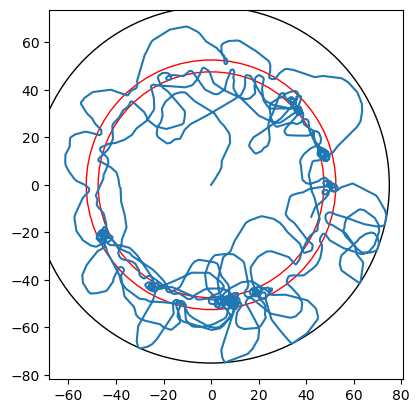

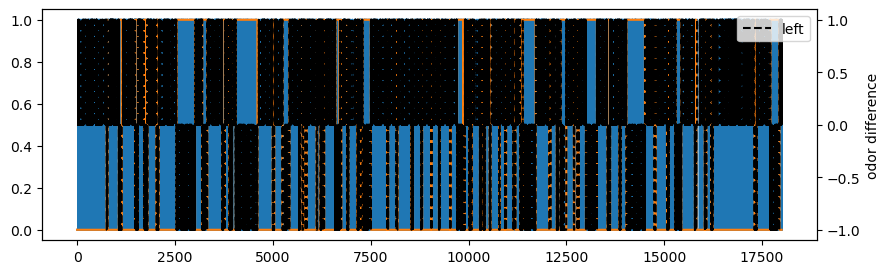

In [46]:
T=5*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=5 # mm (width of the trail)

walking_speed=10 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=20 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)

walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
N=int(T*fps) # number of frames in the simulation
state = np.zeros(N) # state of the fly (0=stop, 1=walking)
heading = np.zeros(N) # heading of the fly (rad)
x = np.zeros(N) # x position of the fly (mm)
y = np.zeros(N) # y position of the fly (mm)
odors = np.zeros((N,2)) # odor concentration at the left and right antennae


heading[0]=np.random.rand()*2*np.pi # initial heading
at_wall=False
odor_asymmetry_seen=False

for i in tqdm(range(1,N)):
    # update state
    if state[i-1]==0: # in the stop state
        if np.random.rand()<rate_stop_to_walk: # transition to walking state
            state[i]=1
        else:
            state[i]=0
    else:
        if np.random.rand()<rate_walk_to_stop: # transition to stop state
            state[i]=0
        else:
            state[i]=1
    
    # get left and right antennal positions
    left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
    left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
    right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
    right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance
    odor_left=get_odor(left_x,left_y)
    odor_right=get_odor(right_x,right_y)
    if ablation_direction=="left":
        odor_left=np.random.binomial(1,ablation_intensity)*(odor_left if odor_sensitive_ablation else 1)
    elif ablation_direction=="right":
        odor_right=np.random.binomial(1,ablation_intensity)*(odor_right if odor_sensitive_ablation else 1)
    
    # update odor estimate assuming decay process
    odors[i,0]=odors[i-1,0]+(odor_left*odor_magnitude-odors[i-1,0])/odor_integration_timescale
    odors[i,1]=odors[i-1,1]+(odor_right*odor_magnitude-odors[i-1,1])/odor_integration_timescale

    # update position based on state
    if state[i]==0: # in the stop state
        x[i]=x[i-1]
        y[i]=y[i-1]
        heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
    else: # in the walking state
        # sample a turn
        if odor_left>odor_right:
            turn_direction=1
            odor_asymmetry_seen=True
            # print('left')
        elif odor_right>odor_left:
            turn_direction=-1
            odor_asymmetry_seen=True
            # print('right')
        else:
            turn_direction=np.random.choice([-1,1])
            odor_asymmetry_seen=False

        if at_wall: # if fly is at the wall, it must turn
            heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            at_wall=False
        elif np.random.rand()<turn_rate+np.abs(odor_right-odor_left)*asymmetry_factor: # turn
            heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
        else:
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        # move forward
        new_x=x[i-1]+np.cos(heading[i])*walking_distance
        new_y=y[i-1]+np.sin(heading[i])*walking_distance
        # check if fly is outside the arena
        if np.sqrt(new_x**2+new_y**2)>arena_radius:
            # animal stops at the wall
            x[i]=x[i-1]
            y[i]=y[i-1]
            at_wall=True
        else:
            x[i]=new_x
            y[i]=new_y

fig, ax = plt.subplots()
# plot the trajectory
ax.plot(x,y)
# plot the arena
circle=plt.Circle((0,0),arena_radius,fill=False)
ax.add_artist(circle)
# plot the trail
circle=plt.Circle((0,0),trail_start_radius,fill=False,color='red')
ax.add_artist(circle)
circle=plt.Circle((0,0),trail_end_radius,fill=False,color='red')
ax.add_artist(circle)
# set the aspect of the plot to be equal
ax.set_aspect('equal')
plt.show()

# plot the odor concentration
plt.figure(figsize=(10,3))
plt.plot(odors)
# also plot the difference in odor concentration on a twinx axis
plt.twinx()
plt.plot(odors[:,0]-odors[:,1],'k--')
plt.ylabel('odor difference')
plt.legend(['left','right'])
plt.show()


In [35]:
# Save as a video (openCV mp4)
import cv2
import datetime
WIDTH, HEIGHT = 1000, 1000
SPEEDUP=20
HARD_SUBSAMPLE=1
SOFT_SUBSAMPLE=10
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
filename = 'fly_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_ablation_'+ablation_direction+'_'+str(ablation_intensity)+'.mp4'
video = cv2.VideoWriter(filename, fourcc, fps*SPEEDUP/(HARD_SUBSAMPLE*SOFT_SUBSAMPLE), (WIDTH, HEIGHT))

X_min,X_max=-np.max(np.abs(x)),np.max(np.abs(x))
Y_min,Y_max=-np.max(np.abs(y)),np.max(np.abs(y))

trj = np.ones((WIDTH,HEIGHT,3),dtype=np.uint8)*255
overlay = np.ones((WIDTH,HEIGHT,3),dtype=np.uint8)*255

# draw the arena
cv2.circle(trj, (int(WIDTH/2),int(HEIGHT/2)), int(arena_radius/(X_max-X_min)*WIDTH), (255,0,0), 5)

# draw the trail
trail_average_radius=(trail_start_radius+trail_end_radius)/2
cv2.circle(trj, (int(WIDTH/2),int(HEIGHT/2)), int(trail_average_radius/(X_max-X_min)*WIDTH), (0,0,255), int(trail_width/(X_max-X_min)*WIDTH))

for i in tqdm(range(1,N,HARD_SUBSAMPLE)):
    # draw line
    x0=int((x[i]-X_min)/(X_max-X_min)*WIDTH)
    y0=int((y[i]-Y_min)/(Y_max-Y_min)*HEIGHT)
    x1=int((x[i-1]-X_min)/(X_max-X_min)*WIDTH)
    y1=int((y[i-1]-Y_min)/(Y_max-Y_min)*HEIGHT)
    cv2.line(trj, (x0,y0), (x1,y1), (0,0,0), 2)
    # draw elliptical fly on overlay
    overlay[:,:,:]=255
    cv2.ellipse(overlay, (x0,y0), (10,5), np.rad2deg(heading[i]), 0, 360, (0,0,255), -1)
    # combine overlay and trj
    full = cv2.addWeighted(overlay, 0.5, trj, 0.5, 0)
    # add to video
    if i%SOFT_SUBSAMPLE==0:
        video.write(full)
video.release()

  0%|          | 0/17999 [00:00<?, ?it/s]

# Forced Bilaterality

  0%|          | 0/215999 [00:00<?, ?it/s]

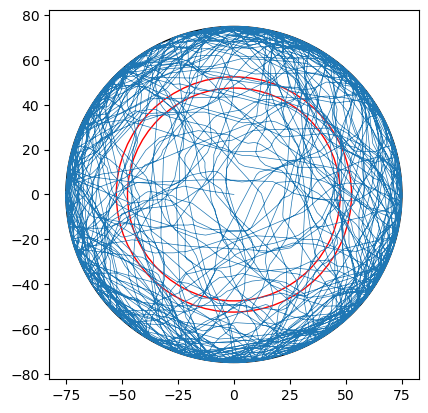

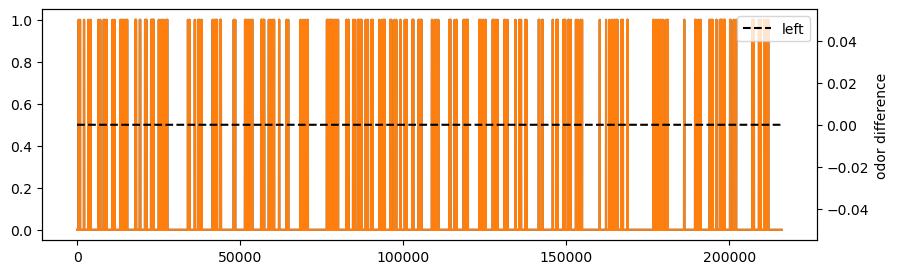

In [38]:
T=60*60 # s (duration of the simulation)
fps=60 # Hz (frame rate of the simulation)
arena_radius=75 # mm (radius of the arena)

trail_radius=50 # mm (radius of the trail)
trail_width=5 # mm (width of the trail)

walking_speed=10 # mm/s (speed of the walking state of the fly)
rotation_diffusion=np.deg2rad(0.22) # rad/s (sd of rotation diffusion)
turn_rate=1.0 # Hz (rate of turning in the turning state of the fly)
asymmetry_factor=20 # (increase in turn rate when odor asymmetry is detected)
turn_magnitude_range= np.deg2rad((8,30)) # rad (range of turn magnitudes in the turning state of the fly)
rate_stop_to_walk=0.5 # Hz (rate of transition from the stop state to the walking state)
rate_walk_to_stop=0.05 # Hz (rate of transition from the walking state to the stop state)

odor_integration_timescale=1/fps # s (timescale of odor integration)
odor_magnitude=1 # (magnitude of the odor signal)

# antennal distance
antennal_distance=1 # mm

# PROCESSING
trail_start_radius=trail_radius-trail_width/2
trail_end_radius=trail_radius+trail_width/2

# get odor function
def get_odor(x,y):
    # x,y are the position of the fly in mm
    # return the odor concentration at that position
    if np.sqrt(x**2+y**2)>trail_start_radius and np.sqrt(x**2+y**2)<trail_end_radius:
        return 1
    return 0

# ASSUME ALL PROCESSES ARE POISSON
turn_rate=turn_rate/fps # 1/frame (rate of turning in the turning state of the fly)
asymmetry_factor=asymmetry_factor/fps # 1/frame (increase in turn rate when odor asymmetry is detected)
rate_stop_to_walk=rate_stop_to_walk/fps # 1/frame (rate of transition from the stop state to the walking state)
rate_walk_to_stop=rate_walk_to_stop/fps # 1/frame (rate of transition from the walking state to the stop state)

odor_integration_timescale=odor_integration_timescale*fps # frames (timescale of odor integration)

walking_distance=walking_speed/fps # mm/frame (distance covered by the fly in one frame in the walking state)
N=int(T*fps) # number of frames in the simulation
state = np.zeros(N) # state of the fly (0=stop, 1=walking)
heading = np.zeros(N) # heading of the fly (rad)
x = np.zeros(N) # x position of the fly (mm)
y = np.zeros(N) # y position of the fly (mm)
odors = np.zeros((N,2)) # odor concentration at the left and right antennae


heading[0]=np.random.rand()*2*np.pi # initial heading
at_wall=False
odor_asymmetry_seen=False

for i in tqdm(range(1,N)):
    # update state
    if state[i-1]==0: # in the stop state
        if np.random.rand()<rate_stop_to_walk: # transition to walking state
            state[i]=1
        else:
            state[i]=0
    else:
        if np.random.rand()<rate_walk_to_stop: # transition to stop state
            state[i]=0
        else:
            state[i]=1
    
    # get left and right antennal positions
    left_x=x[i-1]+np.cos(heading[i-1]+np.pi/2)*antennal_distance
    left_y=y[i-1]+np.sin(heading[i-1]+np.pi/2)*antennal_distance
    right_x=x[i-1]+np.cos(heading[i-1]-np.pi/2)*antennal_distance
    right_y=y[i-1]+np.sin(heading[i-1]-np.pi/2)*antennal_distance
    odor_left=get_odor(left_x,left_y)
    odor_right=get_odor(right_x,right_y)
    # forces same odor on both sides
    odor_left, odor_right = np.max([odor_left, odor_right]), np.max([odor_left, odor_right])
    
    # update odor estimate assuming decay process
    odors[i,0]=odors[i-1,0]+(odor_left*odor_magnitude-odors[i-1,0])/odor_integration_timescale
    odors[i,1]=odors[i-1,1]+(odor_right*odor_magnitude-odors[i-1,1])/odor_integration_timescale

    # update position based on state
    if state[i]==0: # in the stop state
        x[i]=x[i-1]
        y[i]=y[i-1]
        heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
    else: # in the walking state
        # sample a turn
        if odor_left>odor_right:
            turn_direction=1
            odor_asymmetry_seen=True
            # print('left')
        elif odor_right>odor_left:
            turn_direction=-1
            odor_asymmetry_seen=True
            # print('right')
        else:
            turn_direction=np.random.choice([-1,1])
            odor_asymmetry_seen=False

        if at_wall: # if fly is at the wall, it must turn
            heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
            at_wall=False
        elif np.random.rand()<turn_rate+np.abs(odor_right-odor_left)*asymmetry_factor: # turn
            heading[i]=heading[i-1]+ np.random.uniform(*turn_magnitude_range)*turn_direction + np.random.randn()*rotation_diffusion
        else:
            heading[i]=heading[i-1]+np.random.randn()*rotation_diffusion
        # move forward
        new_x=x[i-1]+np.cos(heading[i])*walking_distance
        new_y=y[i-1]+np.sin(heading[i])*walking_distance
        # check if fly is outside the arena
        if np.sqrt(new_x**2+new_y**2)>arena_radius:
            # animal stops at the wall
            x[i]=x[i-1]
            y[i]=y[i-1]
            at_wall=True
        else:
            x[i]=new_x
            y[i]=new_y

fig, ax = plt.subplots()
# plot the trajectory
ax.plot(x,y,linewidth=0.5)
# plot the arena
circle=plt.Circle((0,0),arena_radius,fill=False)
ax.add_artist(circle)
# plot the trail
circle=plt.Circle((0,0),trail_start_radius,fill=False,color='red')
ax.add_artist(circle)
circle=plt.Circle((0,0),trail_end_radius,fill=False,color='red')
ax.add_artist(circle)
# set the aspect of the plot to be equal
ax.set_aspect('equal')
plt.show()

# plot the odor concentration
plt.figure(figsize=(10,3))
plt.plot(odors)
# also plot the difference in odor concentration on a twinx axis
plt.twinx()
plt.plot(odors[:,0]-odors[:,1],'k--')
plt.ylabel('odor difference')
plt.legend(['left','right'])
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def func(theta,A,o):
    theta_ = theta+A*np.sin(theta) + 2*np.pi*o
    theta_ = np.mod(theta_,2*np.pi)
    return theta_

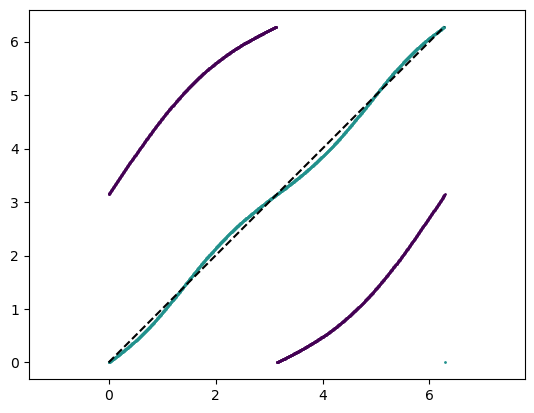

In [50]:
# plot the phase portrait
fig, ax = plt.subplots()
thetas = np.linspace(0,2*np.pi,1000)
ORDER = 2
o = 1/ORDER
A = 0.5
# plot the phase portrait
# plot recurrent dynamics
vals = thetas.copy()
for i in range(ORDER):
    plt.scatter(thetas,func(vals,A,o),color=plt.cm.viridis(i/ORDER),s=1)
    vals = func(vals,A,o)
# plt.scatter(thetas,func(func(thetas,A,o),A,o),s=1)
plt.plot(thetas,thetas,'k--')
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
plt.axis('equal')
plt.show()
